### To do: 

- include a more complex smb forcing (pdd)
- include saliency / atribute maps from gradients
- Design a new experiment where I reconstruct temperature and precipitiation, evolution maps (screenshots) during deglaciation.
- Use observed glacier extent from the years in the inversion problem. Try to reconstruct the climate


In [1]:
# Import the necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import math
import time
from torch.utils.checkpoint import checkpoint
from utils import print_gpu_utilization, print_peak_gpu_memory, device
from visualization import plot_gradient_evolution,plot_loss_components,visualize

You are working on cuda device


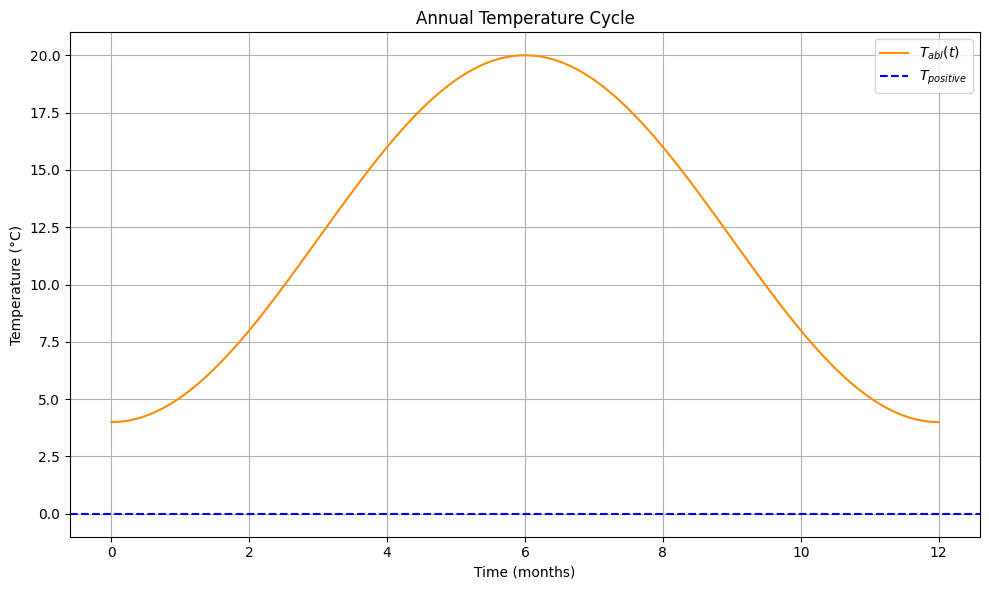

the integral is :  nan


/tmp/ipykernel_182846/3222868282.py:27: RuntimeWarning: invalid value encountered in arccos
  T_ma * (A - (A / np.pi) * np.arccos(ratio)) +
/tmp/ipykernel_182846/3222868282.py:28: RuntimeWarning: invalid value encountered in sqrt
  ((T_mj - T_ma) * A / np.pi) * np.sqrt(1 - ratio**2))


In [2]:

# Constants
T_ma =12  # Mean annual temperature in degrees Celsius
T_mj = 20 # Temperature in the hottest month in degrees Celsius
A = 12     # Period in months (one year)

# Time array: monthly resolution for a full year
t = np.linspace(0, A, 300)

# Temperature function
T_abl = T_ma - (T_mj - T_ma) * np.cos(2 * np.pi * t / A)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, T_abl, label=r'$T_{abl}(t)$', color='darkorange')
plt.axhline(y=0, color='blue', linestyle='--', label=r'$T_{positive}$')
plt.title('Annual Temperature Cycle')
plt.xlabel('Time (months)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('annual_temp.png')
plt.show()

ratio= T_ma / (T_mj - T_ma)
integral = (
            T_ma * (A - (A / np.pi) * np.arccos(ratio)) +
            ((T_mj - T_ma) * A / np.pi) * np.sqrt(1 - ratio**2))
print("the integral is : ",integral)


In [3]:
def compute_integral_positive_temperature(T_ma, T_mj):
    """
    Computes the integral of T_abl(t) over the period where T_abl > 0 (PyTorch version).
    """
    A = 12.0  # months
    ratio = T_ma / (T_mj - T_ma)
    integral = torch.zeros_like(T_ma)

    valid = ratio < 1
    ratio_valid = torch.clamp(ratio[valid], -1.0, 1.0)

    integral[valid] = (
        T_ma[valid] * (A - (A / torch.pi) * torch.acos(ratio_valid)) +
        ((T_mj[valid] - T_ma[valid]) * A / torch.pi) * torch.sqrt(1 - ratio_valid**2)
    )

    return integral

def apply_lapse_rate(topography, T_ma_lowest, T_mj_lowest):
    lapse_rate = 7.0 / 1000.0  # 6°C/km
    min_altitude = torch.min(topography)
    delta_alt = topography - min_altitude

    T_ma = T_ma_lowest - lapse_rate * delta_alt
    T_mj = T_mj_lowest - lapse_rate * delta_alt

    return T_ma, T_mj

def compute_negative_temperature_ratio(T_ma, T_mj):
    """
    Computes the ratio of the year when the temperature is negative (PyTorch version).
    Parameters:
        T_ma (Tensor): 2D tensor of mean annual temperatures (on device)
        T_mj (Tensor): 2D tensor of hottest month temperatures (on device)
    Returns:
        Tensor: 2D tensor of negative temperature ratios (values between 0 and 1)
    """
    ratio = T_ma / (T_mj - T_ma)
    neg_temp_ratio = torch.zeros_like(T_ma)
    # Case 1: Always positive temp
    mask_always_positive = ratio >= 1
    neg_temp_ratio[mask_always_positive] = 0.0
    # Case 2: Always negative temperatures
    mask_always_negative = ratio <= -1
    neg_temp_ratio[mask_always_negative] = 1.0
    # Case 3: Valid
    mask_valid = (~mask_always_positive) & (~mask_always_negative)
    ratio_valid = torch.clamp(ratio[mask_valid], -1.0, 1.0)
    neg_temp_ratio[mask_valid] = (1.0 / torch.pi) * torch.acos(ratio_valid)

    return neg_temp_ratio


In [4]:
# Define SMB parameters directly
melt_f =2/12 # m water / (C year)
smb_oggm_wat_density = 1000.0
smb_oggm_ice_density = 910.0  #kg/m^3
def update_smb(Z_topo,precipitation, T_ma_lowest,T_mj_lowest):
    """Compute the surface mass balance (SMB)
         Input:  precipitation [Unit: m * y^(-1)]
                 air_temp      [Unit: °C           ]
         Output  smb           [Unit: m ice eq. / y]
    This mass balance routine implements the surface mass balance model of OGGM
    """

    T_ma, T_mj = apply_lapse_rate(Z_topo, T_ma_lowest, T_mj_lowest)
    
    # Compute accumulation

    accumulation= precipitation* compute_negative_temperature_ratio(T_ma, T_mj) # unit: [ m * y^(-1) water ]
    

    # Compute ablation
    ablation = melt_f  *  compute_integral_positive_temperature(T_ma, T_mj)# unit: [m water / (C year)] * [C year]  => m water 
    # Compute SMB and convert to ice equivalent
    smb = (accumulation - ablation).sum(dim=0) * (smb_oggm_wat_density / smb_oggm_ice_density)
    
    return smb

In [5]:
ny, nx = 100, 150
Ly, Lx = ny*100, nx*100
x = torch.linspace(0, Lx, nx, device=device)
y = torch.linspace(0, Ly, ny, device=device)
X, Y = torch.meshgrid(x, y, indexing='xy')

# Parameters
center_x = Lx / 2
center_y = Ly / 2
sigma_x = Lx / 4  # controls width of bell in x
sigma_y = Ly / 4  # controls width of bell in y
flat_radius = 0.0  # radius of the flat top in meters

# Compute squared distances from center
dx2 = (X - center_x)**2
dy2 = (Y - center_y)**2
r2 = dx2 + dy2

# Gaussian elevation, peaking at 4000 m and falling to ~1000 m
gaussian = 1000.0 + 3000.0 * torch.exp(-0.5 * (dx2 / sigma_x**2 + dy2 / sigma_y**2))

# Flatten the center to exactly 4000 m
Z_topo = gaussian.clone()
Z_topo[r2 <= flat_radius**2] = 4000.0


In [6]:
precip = 2.5 # e.g., m/year
T_ma_lowest = 8 # °C at lowest elevation
T_mj_lowest = 20  # °C at lowest elevation

nc_file = netCDF4.Dataset('geology.nc')
# nc_file = netCDF4.Dataset('AIF-v1/output-500.nc')
Z_topo = torch.tensor(nc_file.variables['topg'][:], device=device)

# Constant precipitation
precip_tensor = torch.full((1,*Z_topo.shape), precip, device=device)


smb = update_smb(Z_topo,precip_tensor,T_ma_lowest,T_mj_lowest)



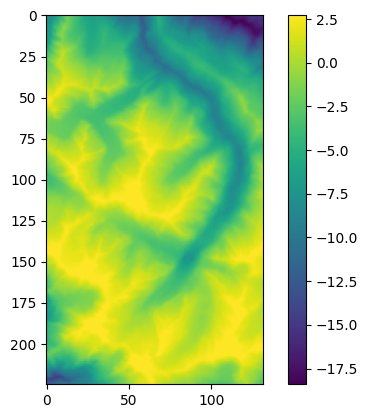

In [7]:
smb_npy = smb.to(torch.float32).detach().cpu().numpy()

plt.imshow(smb_npy)
plt.colorbar()
plt.show()

In [8]:
smb_npy.max()

2.747253

In [9]:
# Prepare hooks for tensors 
def print_hook_b(grad):
    print("\n Gradient is :", torch.norm(grad))
    return grad

def reduce_hook(grad):
    return grad * 1/1.00001

### Prepare the spatial-temporal observations

In [10]:
nc_file = netCDF4.Dataset('geology.nc')
Z_topo = torch.tensor(nc_file.variables['topg'][:], device=device)
topo_1880 = torch.tensor(nc_file.variables['surf_1880'][:], device=device)
thk_1880=topo_1880-Z_topo
thk_1880.to(device=device)
topo_2017 = torch.tensor(nc_file.variables['surf_2017'][:], device=device)
H_init=topo_2017-Z_topo
ttot = 50  # Time limit (yr)
t_start=1880.
grad_b = torch.tensor(0.008, device=device)  # Mass balance gradient
b_max = torch.tensor(2.6, device=device)  # Maximum precip (m/yr)
Z_ELA = torch.tensor(2800.0, device=device)  # Elevation of equilibrium line altitude (m)

rho, g, fd = torch.tensor([910.0, 9.81,0.25e-16], device=device) # units [kg/m^3, m/s^-2, Pa^-3year^-1]
dx=100
dy=100
Lx=Z_topo.shape[1]*dx
Ly=Z_topo.shape[0]*dy
nc_file.close()

In [ ]:
def solve_glacier_dynamics(Z_topo, ttot, grad_b, b_max, Z_ELA, rho=rho, g=g, fd=fd, Lx=Lx, Ly=Ly, dx=dx, dy=dy, dtmax=1, device=device):
    """
    Solve the glacier dynamics using a diffusion-based solver with PyTorch.
    """
    nx = int(Lx / dx)
    ny = int(Ly / dy)
    
    epsilon = torch.tensor(1.e-5, device=device)

    # Initialize ice thickness and surface
    H_ice = torch.zeros((ny, nx), device=device)
    # H_ice=H_init.clone()
    Z_surf = Z_topo + H_ice

    time = torch.tensor(0., device=device) 
    dt = torch.tensor(dtmax, device=device)
    it=0
    t_last_update=0
    t_freq=5
    precip = 2.5 # e.g., m/year
    precip_tensor = torch.full((1,*Z_topo.shape), precip, device=device)
    T_ma_lowest = 7 # °C at lowest elevation
    T_mj_lowest = 20  # °C at lowest elevation
    b = update_smb(Z_surf,precip_tensor,T_ma_lowest,T_mj_lowest)
    while time < ttot:

        time += dt
        it += 1
        # Compute H_avg
        H_avg = 0.25 * (H_ice[:-1, :-1] + H_ice[1:, 1:] + H_ice[:-1, 1:] + H_ice[1:, :-1])
  

        # Compute Snorm
        Sx = (Z_surf[:, 1:] - Z_surf[:, :-1]) / dx
        Sy = (Z_surf[1:, :] - Z_surf[:-1, :]) / dy
        Sx = 0.5 * (Sx[:-1, :] + Sx[1:, :])
        Sy = 0.5 * (Sy[:, :-1] + Sy[:, 1:])
        Snorm = torch.sqrt(Sx**2 + Sy**2 +epsilon)

        # Compute diffusivity
        # Perform high-precision computation for stability


        D = fd * (rho * g)**3.0 * H_avg**5 * Snorm**2 + epsilon
        
        # Compute adaptive time step
        dt = min(min(dx, dy)**2 / (4.1 * torch.max(D).item()), dtmax)

        # Compute fluxes
        qx = -(0.5 * (D[:-1, :] + D[1:, :])) * (Z_surf[1:-1, 1:] - Z_surf[1:-1, :-1]) / dx
        qy = -(0.5 * (D[:, :-1] + D[:, 1:])) * (Z_surf[1:, 1:-1] - Z_surf[:-1, 1:-1]) / dy

        # Compute thickness change rate
        dHdt = -(torch.diff(qx, dim=1) / dx + torch.diff(qy, dim=0) / dy)

        # Update ice thickness
        H_ice[1:-1, 1:-1] += dt * dHdt

        # Compute surface mass balance (SMB)
        # b = torch.minimum(grad_b * (Z_surf - Z_ELA), b_max)
        # Generate precipitation and temperature fields based on topography
        if (time-t_last_update)>=t_freq:
            b = update_smb(Z_surf,precip_tensor,T_ma_lowest,T_mj_lowest)
            t_last_update=time.clone()
        H_ice[1:-1, 1:-1] += dt * b[1:-1, 1:-1]

        # Ensure ice thickness remains positive
        H_ice = torch.maximum(H_ice, torch.tensor(0.0, dtype=torch.float32, device=device))

        # Update surface topography
        Z_surf = Z_topo + H_ice

        # Visualization at specified intervals
        # if it % 100 == 0:
            
            # D[D>10000]=3000
        visualize(Z_surf,time,H_ice,Lx,Ly)
            
   

    return H_ice , it



##### Observations
- work with glacier extents instead of thickness.
- mask where we have dated morains.
- give an age to the morains.

In [ ]:
#Z_ELA = torch.full(Z_topo.shape,3000., requires_grad=True, device=device)
# h,it=solve_glacier_dynamics(Z_topo, ttot, grad_b, b_max, Z_ELA)
# torch.save(h,'Obs_2D.pt')

In [ ]:
plt.plot(h[49,:].cpu().numpy())

In [ ]:
plt.plot(h[:,65].cpu().numpy())
print(h[:,65].max(), torch.sum(h))

In [ ]:
it

In [20]:
class GlacierDynamicsCheckpointed(torch.nn.Module):
    def __init__(self, Z_topo, ttot, rho, g, fd, Lx, Ly, dx, dy, dtmax, device, H_init):
        super().__init__()
        self.Z_topo = Z_topo
        self.H_init=H_init
        self.ttot = ttot
        # self.grad_b = grad_b
        # self.b_max = b_max
        self.rho = rho
        self.g = g
        self.fd = fd
        self.Lx = Lx
        self.Ly = Ly
        self.dx = dx
        self.dy = dy
        self.dtmax = dtmax
        self.device = device
        

    def forward(self, precip_tensor, T_ma_lowest,T_mj_lowest):
        return self.solve_glacier_dynamics(self.Z_topo, self.ttot,self.H_init,precip_tensor, T_ma_lowest,T_mj_lowest)

    def solve_glacier_dynamics(self, Z_topo, ttot, H_initial,precip_tensor, T_ma_lowest,T_mj_lowest):
        nx = int(self.Lx / self.dx)
        ny = int(self.Ly / self.dy)

        epsilon = torch.tensor(1.e-10, device=self.device)
        H_ice = torch.zeros((ny, nx), device=self.device)
        # H_ice = H_initial.to(device=device)
        
        Z_surf = Z_topo + H_ice

        time = torch.tensor(0., device=self.device)
        # dt = torch.tensor(self.dtmax, device=self.device)
        it = 0
        t_freq=5
        t_last_update=0
        #initial smb 
        smb = update_smb(Z_surf,precip_tensor,T_ma_lowest,T_mj_lowest)

        def checkpointed_step(H_ice, Z_surf,smb, time):
            # Compute H_avg
            H_avg = 0.25 * (H_ice[:-1, :-1] + H_ice[1:, 1:] + H_ice[:-1, 1:] + H_ice[1:, :-1])

            # Compute Snorm
            Sx = (Z_surf[:, 1:] - Z_surf[:, :-1]) / self.dx
            Sy = (Z_surf[1:, :] - Z_surf[:-1, :]) / self.dy
            Sx = 0.5 * (Sx[:-1, :] + Sx[1:, :])
            Sy = 0.5 * (Sy[:, :-1] + Sy[:, 1:])
            Snorm = torch.sqrt(Sx**2 + Sy**2 + epsilon)

               
            # Compute diffusivity
            D = self.fd * (self.rho * self.g)**3.0 * H_avg**5 * Snorm**2 + epsilon

            # Compute adaptive time step.
            # Note: To ensure dt remains a tensor (and part of the autograd graph),
            # we construct it via torch operations.
            dt_value = min(min(self.dx, self.dy)**2 / (4.2 * torch.max(D).item()), self.dtmax)
            dt = torch.tensor(dt_value, dtype=torch.float32, device=self.device, requires_grad=True)

            # Register a hook on dt.
            dt.register_hook(lambda grad: print("dt grad norm:", grad.norm().item()))
            
            # Compute fluxes
            qx = -(0.5 * (D[:-1, :] + D[1:, :])) * (Z_surf[1:-1, 1:] - Z_surf[1:-1, :-1]) / self.dx
            qy = -(0.5 * (D[:, :-1] + D[:, 1:])) * (Z_surf[1:, 1:-1] - Z_surf[:-1, 1:-1]) / self.dy

            # Compute thickness change rate
            dHdt = -(torch.diff(qx, dim=1) / self.dx + torch.diff(qy, dim=0) / self.dy)

            # Update ice thickness
            H_ice = H_ice.clone()
            H_ice[1:-1, 1:-1] = H_ice[1:-1, 1:-1] + dt * dHdt

            H_ice = H_ice.clone()
            H_ice[1:-1, 1:-1] = H_ice[1:-1, 1:-1] + dt * smb[1:-1, 1:-1]

            # Ensure ice thickness remains positive
            H_ice = torch.maximum(H_ice, torch.tensor(0.0, dtype=torch.float32, device=self.device))

            # Update surface topography
            Z_surf = Z_topo + H_ice
            return H_ice, Z_surf, time + dt

        while time < ttot:
            
            H_ice, Z_surf, time = checkpoint(checkpointed_step, H_ice, Z_surf, smb, time)
            it += 1
            precip_tensor.register_hook(reduce_hook)
            # Compute surface mass balance (SMB)
            if (time-t_last_update)>=t_freq:
                smb = update_smb(Z_surf,precip_tensor,T_ma_lowest,T_mj_lowest)
                t_last_update=time.clone()

        return H_ice

# Wrap the solve_glacier_dynamics function in the checkpointed module
glacier_model = GlacierDynamicsCheckpointed(Z_topo, ttot, rho, g, fd, Lx, Ly, dx, dy, 1, device,H_init)

# Replace the direct call with a call to the checkpointed model
# H_simulated = glacier_model(precip_tensor, T_ma_lowest,T_mj_lowest)


#### Inversion options 
**Mean Square Error (MSE)**:

* Recomended for the case where we have glacier thickness. Converges the fastest.  


**Intersection over Union (IoU)**: 

* Also known as the **Jaccard Index**, this measures the overlap between simulated and observed extents. We use this option when we do not have information about the glacier thickness.


In [21]:
# # Define a function for the forward computation to use with checkpointing
def checkpointed_inversion_thicknes(precip_tensor, T_ma_lowest,T_mj_lowest,observed_thk, reg_lambda):
    # Perform forward simulation
    H_simulated = glacier_model(precip_tensor, T_ma_lowest,T_mj_lowest)

    # Compute data fidelity term
    data_fidelity = torch.mean(torch.abs(H_simulated - observed_thk) ** 2)

    # Compute smoothness regularization
    smoothness_x = torch.sum((precip_tensor[:, 1:] - precip_tensor[:, :-1]) ** 2)
    smoothness_y = torch.sum((precip_tensor[1:, :] - precip_tensor[:-1, :]) ** 2)
    smoothness_reg = smoothness_x + smoothness_y

    # Total loss
    loss = data_fidelity + reg_lambda * smoothness_reg
    return loss,H_simulated

# Define a function for the forward computation to use with checkpointing
def checkpointed_inversion_extent(precip_tensor,temp_low,temp_high, observed_thk):
    """
    Forward computation with IoU for data fidelity and smoothness regularization.

    Args:
        Z_ELA (torch.Tensor): The equilibrium line altitude field.
        observed_thk (torch.Tensor): The observed glacier thickness.
        reg_lambda (float): Regularization parameter for smoothness.
        threshold (float): Thickness threshold to define glacier extent.

    Returns:
        loss (torch.Tensor): Total loss including IoU and regularization.
        H_simulated (torch.Tensor): Simulated glacier thickness.
    """
    # Perform forward simulation
    H_simulated =  glacier_model(precip_tensor, T_ma_lowest,T_mj_lowest)  # Use the checkpointed glacier model
    
    # Steeper sigmoid using a scaling factor
    scale = 100.0
    mask_simulated = torch.sigmoid(scale * (H_simulated - 1))
    mask_observed = torch.sigmoid(scale * (observed_thk - 1))

    # Compute data fidelity term
    data_fidelity = torch.mean(torch.abs(mask_simulated - mask_observed) ** 2)
    # Compute smoothness regularization
    smoothness_x = torch.sum((precip_tensor[:, 1:] - precip_tensor[:, :-1]) ** 2)
    smoothness_y = torch.sum((precip_tensor[1:, :] - precip_tensor[:-1, :]) ** 2)
    smoothness_reg = smoothness_x + smoothness_y
    
    reg_lambda=0.000
    # Total loss
    loss = data_fidelity + reg_lambda * smoothness_reg

    return loss, H_simulated


In [31]:
# Reset the starting point in tracking maximum GPU memory occupied by tensors in bytes for a given device.
torch.cuda.reset_peak_memory_stats()

# Initial guesses for inversion problem
# precip_tensor = torch.full((1, *Z_topo.shape), 2.0, requires_grad=True, device=device)
precip_tensor = torch.load('percip.pt').to(device).requires_grad_()

T_mj_lowest = torch.tensor(20.0, requires_grad=True, device=device)
T_ma_lowest = torch.tensor(10.0, requires_grad=True, device=device)

# Observed glacier thickness (assumed already loaded as observed_thk tensor)
observed_thk = torch.load('Obs_2D.pt').to(device)

# Hyperparameters
initial_lr = 0.01 
reg_lambda = 5
n_iterations = 10

# Optimizer setup
# optimizer = torch.optim.Adam([precip_tensor], lr=initial_lr)
optimizer = torch.optim.Adam([precip_tensor, T_ma_lowest, T_mj_lowest], lr=initial_lr)


# Tracking variables
total_loss_history = []
data_fidelity_history = []
regularization_history = []
total_gradients_history = []

# Main loop

for i in range(n_iterations):
    start_time = time.time()
    optimizer.zero_grad()
    print(f'Nb iterations: {i + 1} {50*'-'}')
    # precip_tensor.register_hook(print_hook_b)
    # Forward pass with gradient checkpointing
    loss, H_simulated = checkpointed_inversion_thicknes(precip_tensor, T_ma_lowest, T_mj_lowest, observed_thk, reg_lambda)

    # Backward pass
    loss.backward()
    for param in optimizer.param_groups[0]['params']:
        print(f'Gradient of parameters: {torch.norm(param.grad)}') 

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_([precip_tensor, T_ma_lowest, T_mj_lowest], max_norm=100)

    # Optimizer step
    optimizer.step()

    # # Clamp parameter values (only if finite)
    # with torch.no_grad():
    #     if torch.isfinite(precip_tensor).all():
    #         precip_tensor.clamp_(0.0, 5.0)
    #     else:
    #         print("NaN in precip_tensor post-step, resetting to 2.0")
    #         precip_tensor.fill_(2.0)

    #     if torch.isfinite(T_ma_lowest):
    #         T_ma_lowest.clamp_(0.0, 20.0)
    #     else:
    #         print("NaN in T_ma_lowest post-step, resetting to 10.0")
    #         T_ma_lowest.data = torch.tensor(10.0, device=device)

    #     if torch.isfinite(T_mj_lowest):
    #         T_mj_lowest.clamp_(5.0, 30.0)
    #     else:
    #         print("NaN in T_mj_lowest post-step, resetting to 20.0")
    #         T_mj_lowest.data = torch.tensor(20.0, device=device)

    # Log timing
    elapsed_time = time.time() - start_time
    print(f"Iteration {i + 1} took {elapsed_time:.2f} seconds. precip mean = {precip_tensor.mean().item():.3f}")

    # Store history
    total_loss_history.append(loss.item())
    total_gradients_history.append(torch.norm(precip_tensor.grad).item())

    with torch.no_grad():
        data_fidelity = torch.mean((H_simulated - observed_thk) ** 2).item()
        data_fidelity_history.append(data_fidelity)



/tmp/ipykernel_182846/464908127.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  precip_tensor = torch.load('percip.pt').to(device).requires_grad_()
/tmp/ipykernel_182846

Nb iterations: 1 --------------------------------------------------
dt grad norm: 41.450927734375
dt grad norm: 41.45058822631836
dt grad norm: 41.45048522949219
dt grad norm: 41.4522590637207
dt grad norm: 41.45193099975586
dt grad norm: 41.45165252685547
dt grad norm: 41.45152282714844
dt grad norm: 41.451419830322266
dt grad norm: 41.45170593261719
dt grad norm: 41.45185089111328
dt grad norm: 41.451759338378906
dt grad norm: 41.45215606689453
dt grad norm: 41.451904296875
dt grad norm: 41.451690673828125
dt grad norm: 41.451560974121094
dt grad norm: 41.451412200927734
dt grad norm: 41.4512825012207
dt grad norm: 41.45119094848633
dt grad norm: 41.45112609863281
dt grad norm: 41.45245361328125
dt grad norm: 41.453617095947266
dt grad norm: 41.45353698730469
dt grad norm: 41.453433990478516
dt grad norm: 41.45369338989258
dt grad norm: 41.453556060791016
dt grad norm: 41.45357894897461
dt grad norm: 41.453453063964844
dt grad norm: 41.45343017578125
dt grad norm: 41.4535026550293
dt

In [30]:
torch.save(precip_tensor,"percip.pt")

In [24]:
T_mj_lowest,T_ma_lowest

(tensor(19.5701, device='cuda:0', requires_grad=True),
 tensor(9.5644, device='cuda:0', requires_grad=True))

In [25]:
print_gpu_utilization()
print_peak_gpu_memory()

GPU memory occupied: 742 MB.
Peak GPU memory used: 334.66 MB.


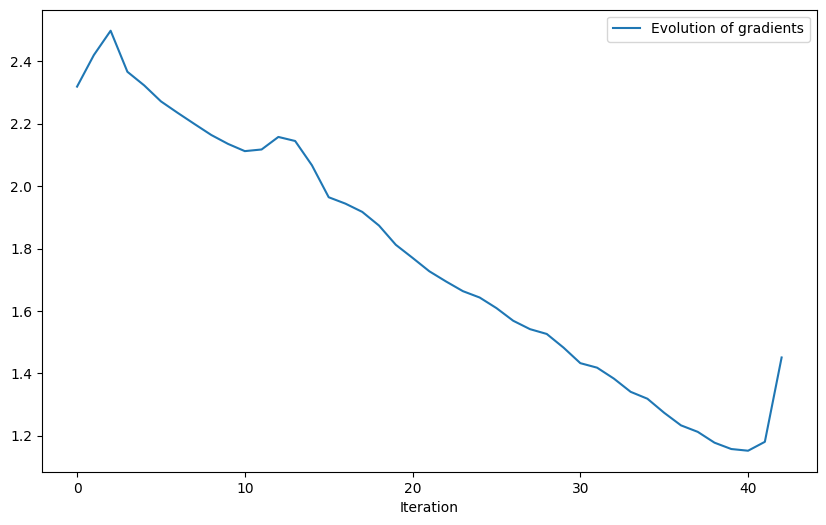

In [26]:
plot_gradient_evolution(total_gradients_history)

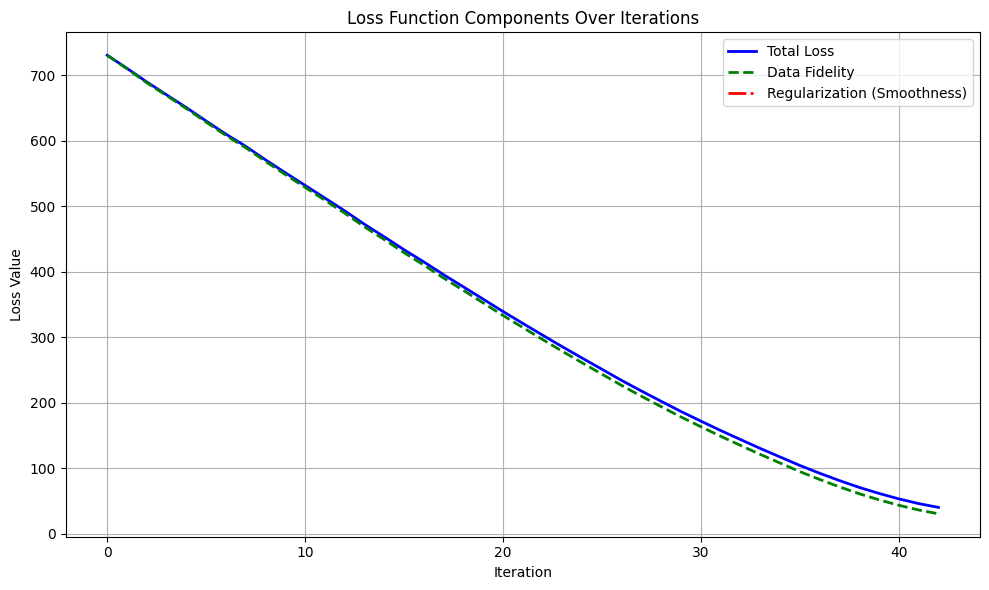

In [27]:
plot_loss_components(total_loss_history, data_fidelity_history, regularization_history)

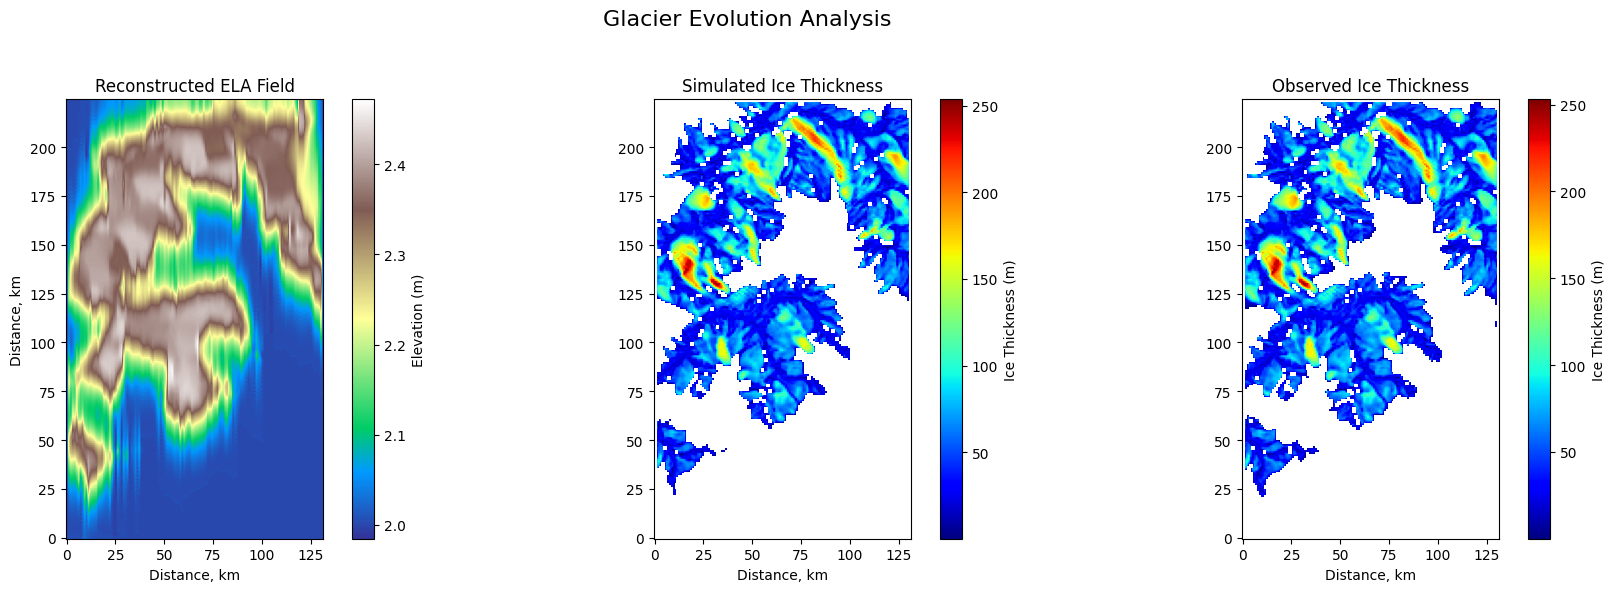

In [28]:
# Convert tensors to NumPy arrays for plotting
Z_ELA_np = precip_tensor.to(torch.float32).detach().cpu().numpy()
H_ice_np = H_simulated.to(torch.float32).detach().cpu().numpy()
mask_observed = observed_thk#torch.sigmoid((observed_thk - 5) * 10.0)
observed_thk_np = mask_observed.to(torch.float32).detach().cpu().numpy()

# Create a figure with three subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize for better layout

# Plot the ELA field
im1 = ax[0].imshow(Z_ELA_np[0], cmap='terrain', origin='lower')
fig.colorbar(im1, ax=ax[0], orientation='vertical', label='Elevation (m)')
ax[0].set_title('Reconstructed ELA Field')
ax[0].set_xlabel('Distance, km')
ax[0].set_ylabel('Distance, km')

# Second subplot: Ice thickness (simulated)
im2 = ax[1].imshow(np.where(H_ice_np > 0, H_ice_np, np.nan), cmap='jet', origin='lower')
fig.colorbar(im2, ax=ax[1], orientation='vertical', label='Ice Thickness (m)')
ax[1].set_title('Simulated Ice Thickness')
ax[1].set_xlabel('Distance, km')

# Third subplot: Observed ice thickness
im3 = ax[2].imshow(np.where(observed_thk_np > 0, observed_thk_np, np.nan), cmap='jet', origin='lower')
fig.colorbar(im3, ax=ax[2], orientation='vertical', label='Ice Thickness (m)')
ax[2].set_title('Observed Ice Thickness')
ax[2].set_xlabel('Distance, km')

# Add a main title
fig.suptitle('Glacier Evolution Analysis', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plots
plt.show()


In [ ]:
# Steeper sigmoid using a scaling factor (e.g., 10)
scale = 100.0
mask_simulated = torch.sigmoid(scale * (H_simulated - 1))
mask_observed = torch.sigmoid(scale * (observed_thk - 1))


# Convert tensors to NumPy arrays for plotting
Z_ELA_np = (torch.abs(mask_simulated - mask_observed) ** 2).to(torch.float32).detach().cpu().numpy()
H_ice_np = mask_simulated.to(torch.float32).detach().cpu().numpy()
observed_thk_np = mask_observed.to(torch.float32).detach().cpu().numpy()

# Create a figure with three subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize for better layout

# Plot the ELA field
im1 = ax[0].imshow(Z_ELA_np, cmap='terrain', origin='lower')
fig.colorbar(im1, ax=ax[0], orientation='vertical', label='Elevation (m)')
ax[0].set_title('Residual')
ax[0].set_xlabel('Distance, km')
ax[0].set_ylabel('Distance, km')

# Second subplot: Ice thickness (simulated)
im2 = ax[1].imshow(H_ice_np, cmap='jet', origin='lower')
fig.colorbar(im2, ax=ax[1], orientation='vertical', label='Ice Thickness (m)')
ax[1].set_title('Simulated Ice Thickness')
ax[1].set_xlabel('Distance, km')

# Third subplot: Observed ice thickness
im3 = ax[2].imshow(observed_thk_np, cmap='jet', origin='lower')
fig.colorbar(im3, ax=ax[2], orientation='vertical', label='Ice Thickness (m)')
ax[2].set_title('Observed Ice Thickness')
ax[2].set_xlabel('Distance, km')

# Add a main title
fig.suptitle('Glacier Evolution Analysis', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("Inversion_results")
# Display the plots
plt.show()

### Memory usage for dx = 2000 m


| **Iterations**          | **Time**        | **GPU Memory:**           |
|-------------------------|-----------------|---------------------------|
| 3700               |100 yr               | 950                        |
| 35000              |200 yr               | 4000                       |
| 11400              |300  yr                 | 8000                      |
